In [1]:
import os
import sys

sys.path.append(os.path.abspath(os.path.join("..")))
print(os.path.abspath(os.path.join("..")))

/media/edint/64d115f7-57cc-417b-acf0-7738ac091615/Ivern/WorkSpace/CNN


In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset

import os
import pandas as pd
import numpy as np


class FER2013Dataset(Dataset):
    """
    FER2013 CSV 데이터셋
    - columns: ['emotion', 'pixels', 'Usage']
    - pixels: 공백으로 구분된 48x48 (그레이스케일)
    - Usage: 'Training', 'PublicTest', 'PrivateTest'
    """

    def __init__(self, csv_path, usage="Training", transform=None):
        self.data = pd.read_csv(csv_path)
        self.data = self.data[self.data["Usage"] == usage].reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img = np.fromstring(row["pixels"], dtype=np.uint8, sep=" ").reshape(48, 48)

        # 그레이스케일(1채널) → 3채널 복제 (MobileNet 호환)
        img = np.repeat(img[..., np.newaxis], 3, axis=2)

        if self.transform:
            img = self.transform(img)

        label = int(row["emotion"])
        return img, label


def download_fer2013_dataset(
    csv_path="./data/fer2013.csv", batch_size=64, num_workers=4
):
    """
    FER2013 데이터셋 로드 함수
    - FER2013 CSV 파일은 https://www.kaggle.com/datasets/deadskull7/fer2013 에서 다운로드 가능
    """
    if not os.path.exists(csv_path):
        print(csv_path)
        print(os.getcwd())
        raise FileNotFoundError(
            f"'{csv_path}' not found. Please download fer2013.csv first."
        )

    # 이미지 전처리 정의
    transform_train = transforms.Compose(
        [
            transforms.ToPILImage(),
            transforms.Resize(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )

    transform_test = transforms.Compose(
        [
            transforms.ToPILImage(),
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )

    # FER2013 CSV 분할 로드
    trainset = FER2013Dataset(csv_path, usage="Training", transform=transform_train)
    valset = FER2013Dataset(csv_path, usage="PublicTest", transform=transform_test)
    testset = FER2013Dataset(csv_path, usage="PrivateTest", transform=transform_test)

    # 데이터로더 정의
    trainloader = DataLoader(
        trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers
    )
    valloader = DataLoader(
        valset, batch_size=batch_size, shuffle=False, num_workers=num_workers
    )
    testloader = DataLoader(
        testset, batch_size=batch_size, shuffle=False, num_workers=num_workers
    )

    print(
        f"Loaded FER2013 dataset: train={len(trainset)} val={len(valset)} test={len(testset)}"
    )

    return {"train": trainloader, "val": valloader, "test": testloader}


In [3]:
loader_dict = download_fer2013_dataset()
train_loader = loader_dict["train"]
test_loader = loader_dict["test"]


# FER-2013 클래스 이름
classes = ("angry", "disgust", "fear", "happy", "sad", "surprise", "neutral")

# 테스트셋에서 일부 샘플 가져오기
dataiter = iter(test_loader)
images, labels = next(dataiter)

Loaded FER2013 dataset: train=28709 val=3589 test=3589


In [4]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

IMAGENET_MEAN = np.array([0.485, 0.456, 0.406]).reshape(3,1,1)
IMAGENET_STD  = np.array([0.229, 0.224, 0.225]).reshape(3,1,1)

def denorm(img_tensor):
    """img_tensor: (3,H,W), CPU"""
    x = img_tensor.detach().cpu().numpy()
    x = (x * IMAGENET_STD + IMAGENET_MEAN).clip(0,1)
    x = np.transpose(x, (1,2,0))  # HWC
    return x

@torch.no_grad()
def predict_all(model, loader, device):
    model.eval().to(device)
    all_preds, all_probs, all_gts = [], [], []
    samples = []  # 시각화를 위해 일부 이미지 저장

    for imgs, labels in loader:
        imgs = imgs.to(device)
        logits = model(imgs)
        probs = F.softmax(logits, dim=1)

        preds = probs.argmax(1).cpu().numpy()
        gts   = labels.cpu().numpy()
        all_preds.append(preds)
        all_probs.append(probs.cpu().numpy())
        all_gts.append(gts)

        # 시각화 샘플 저장 (최대 128장 정도만)
        if len(samples) < 128:
            for i in range(min(imgs.size(0), 128 - len(samples))):
                samples.append( (imgs[i].cpu(), gts[i], preds[i], probs[i].cpu().numpy()) )

    all_preds = np.concatenate(all_preds)
    all_probs = np.concatenate(all_probs)
    all_gts   = np.concatenate(all_gts)
    return all_preds, all_probs, all_gts, samples

@torch.no_grad()
def show_batch_grid(loader, model, device="cpu", n=8, cols=4, only_errors=False, save_path=None):
    """
    loader: test loader
    n: 보여줄 샘플 수
    only_errors: 오답만 모아보기
    """
    model.eval().to(device)

    # 배치 하나 꺼내기 (필요하면 여러 배치 순회)
    imgs, labels = next(iter(loader))
    imgs = imgs.to(device)
    labels = labels.to(device)

    logits = model(imgs)
    probs = F.softmax(logits, dim=1)
    preds = probs.argmax(1)

    # 시각화용 샘플 준비
    samples = []
    for i in range(imgs.size(0)):
        correct = (preds[i] == labels[i]).item()
        if (only_errors and not correct):
            samples.append((imgs[i].cpu(), int(labels[i]), int(preds[i]), float(probs[i, preds[i]])))
        elif not only_errors:
            samples.append((imgs[i].cpu(), int(labels[i]), int(preds[i]), float(probs[i, preds[i]])))
        if len(samples) >= n:
            break

    if len(samples) == 0:
        print("표시할 샘플이 없습니다. (배치에 오답이 없거나 너무 작은 n)")
        return

    rows = int(np.ceil(len(samples)/cols))
    plt.figure(figsize=(cols*3, rows*3))
    for i, (img, gt, pred, p) in enumerate(samples, 1):
        plt.subplot(rows, cols, i)
        plt.imshow(denorm(img))
        ok = (gt == pred)
        title = f"Pred: {classes[pred]}\nTrue: {classes[gt]}"
        plt.title(title, color=("green" if ok else "red"), fontsize=10)
        plt.axis("off")
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=180, bbox_inches="tight")
        print(f"Saved grid to {save_path}")
    plt.show()

def plot_confusion_matrix(cm, classes, normalize=True, title="Confusion Matrix"):
    if normalize:
        cm = cm.astype("float") / (cm.sum(axis=1, keepdims=True) + 1e-12)
    plt.figure(figsize=(7,6))
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha="right")
    plt.yticks(tick_marks, classes)
    fmt = ".2f" if normalize else "d"
    thresh = cm.max() * 0.6
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black", fontsize=9)
    plt.ylabel("True")
    plt.xlabel("Pred")
    plt.tight_layout()


# ====== 6) 갤러리(정답/오답) 그리드 ======
def show_gallery(samples, classes, n=24, only_errors=False, cols=6, title="Samples"):
    # samples: list of (img(3,H,W), gt, pred, prob(np.array))
    if only_errors:
        samples = [s for s in samples if s[1] != s[2]]
    if len(samples) == 0:
        print("No samples to display.")
        return
    n = min(n, len(samples))
    rows = int(np.ceil(n / cols))
    plt.figure(figsize=(cols*2.6, rows*2.6))
    for i in range(n):
        img, gt, pred, prob = samples[i]
        plt.subplot(rows, cols, i+1)
        plt.imshow(denorm(img))
        ttl = f"GT:{classes[gt]}\nPred:{classes[pred]} ({prob[pred]:.2f})"
        color = "green" if gt == pred else "red"
        plt.title(ttl, color=color, fontsize=9)
        plt.axis("off")
    plt.suptitle(title)
    plt.tight_layout()

Device : cuda
model exist : True
TEST  Acc: 0.6367 | F1(macro): 0.6226
              precision    recall  f1-score   support

       angry      0.548     0.542     0.545       491
     disgust      0.800     0.509     0.622        55
        fear      0.472     0.498     0.485       528
       happy      0.856     0.862     0.859       879
         sad      0.477     0.517     0.496       594
    surprise      0.820     0.714     0.763       416
     neutral      0.588     0.585     0.587       626

    accuracy                          0.637      3589
   macro avg      0.652     0.604     0.623      3589
weighted avg      0.643     0.637     0.639      3589



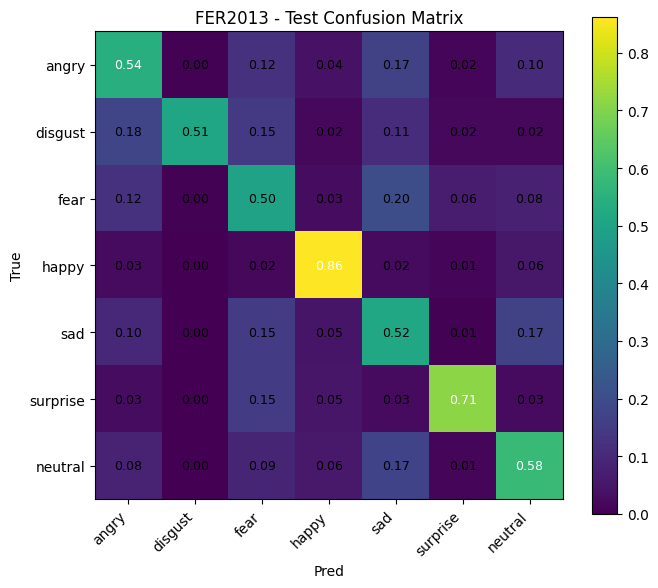

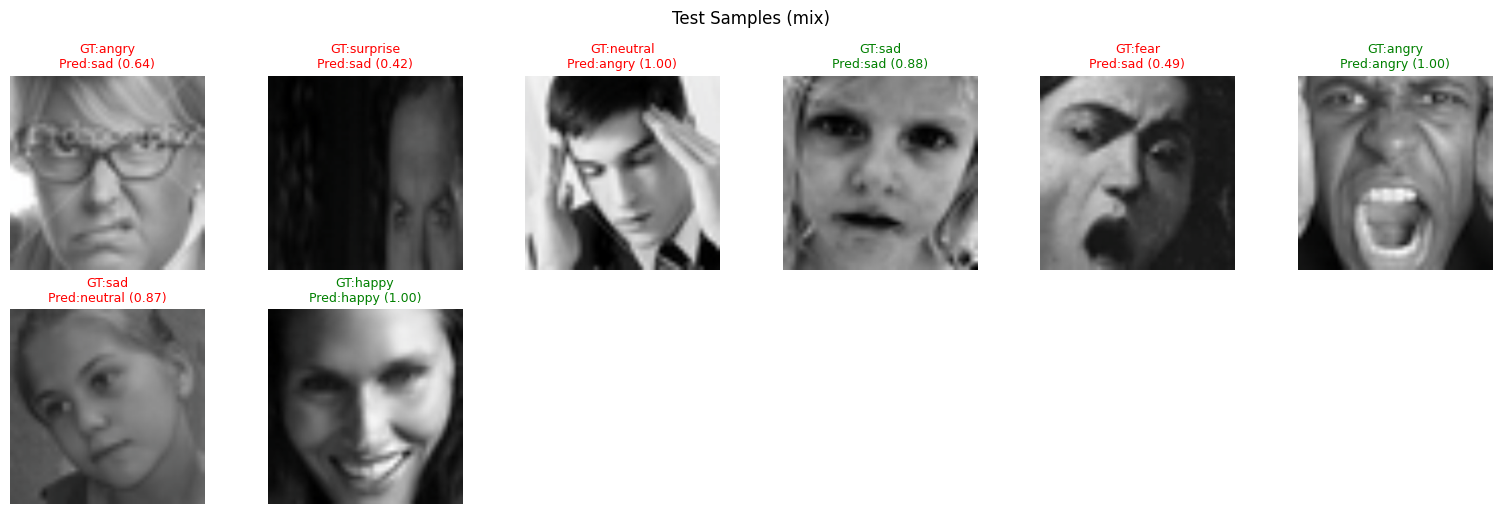

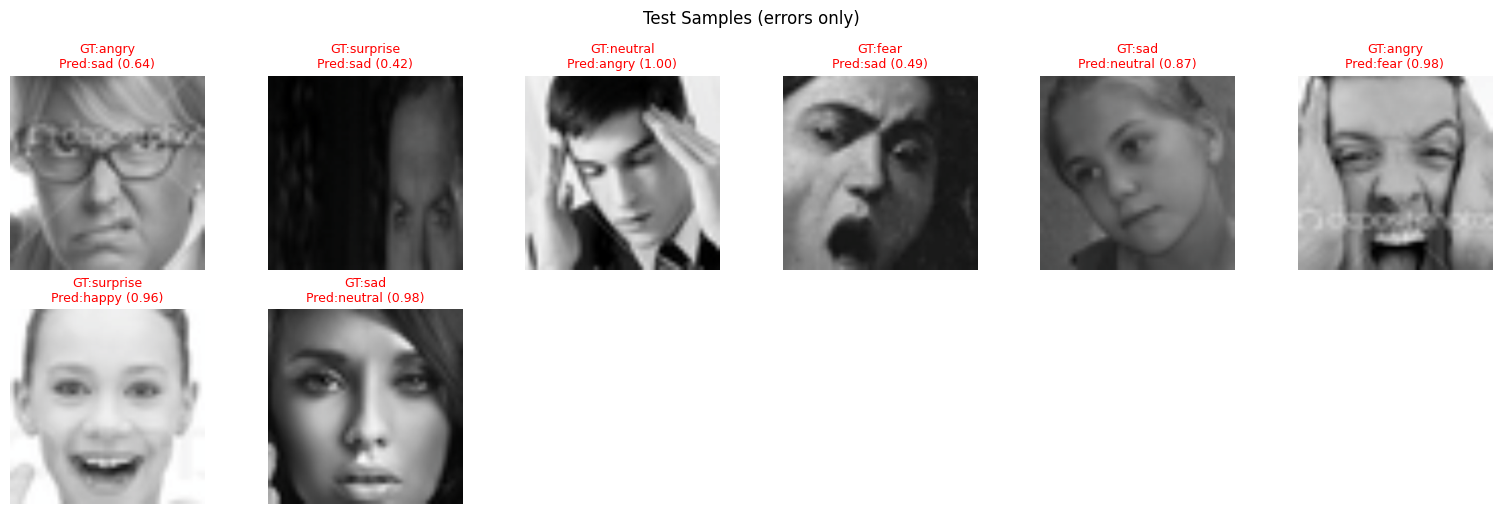

In [14]:
from mobilenet.mobilenet_3 import MobileNetV3Large
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device : {device}")
model = MobileNetV3Large(num_classes=7).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

model_path = "mobilenetv3_large_fer2013.pth"
print(f'model exist : {os.path.exists(model_path)}')
# 모델을 평가 모드로 전환
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

preds, probs, gts, samples = predict_all(model, test_loader, device=device)

    # 4) 지표 출력
acc = accuracy_score(gts, preds)
f1m = f1_score(gts, preds, average="macro")
print(f"TEST  Acc: {acc:.4f} | F1(macro): {f1m:.4f}")
print(classification_report(gts, preds, target_names=classes, digits=3))

# 5) 혼동행렬
cm = confusion_matrix(gts, preds, labels=list(range(len(classes))))
plot_confusion_matrix(cm, classes, normalize=True, title="FER2013 - Test Confusion Matrix")
plt.show()

# 6) 갤러리 (전체 샘플)
show_gallery(samples, classes, n=8, only_errors=False, title="Test Samples (mix)")
plt.show()

# 7) 갤러리 (오답만)
show_gallery(samples, classes, n=8, only_errors=True, title="Test Samples (errors only)")
plt.show()

# show_batch_grid(test_loader, model, device=device,
#                     n=8, cols=4,
#                     only_errors='store_true',
#                     save_path=(""))

Device : cuda
model exist : True
TEST  Acc: 0.6748 | F1(macro): 0.6517
              precision    recall  f1-score   support

       angry      0.585     0.615     0.600       491
     disgust      0.494     0.745     0.594        55
        fear      0.522     0.477     0.499       528
       happy      0.900     0.844     0.871       879
         sad      0.545     0.549     0.547       594
    surprise      0.755     0.832     0.792       416
     neutral      0.659     0.660     0.659       626

    accuracy                          0.675      3589
   macro avg      0.637     0.675     0.652      3589
weighted avg      0.678     0.675     0.675      3589



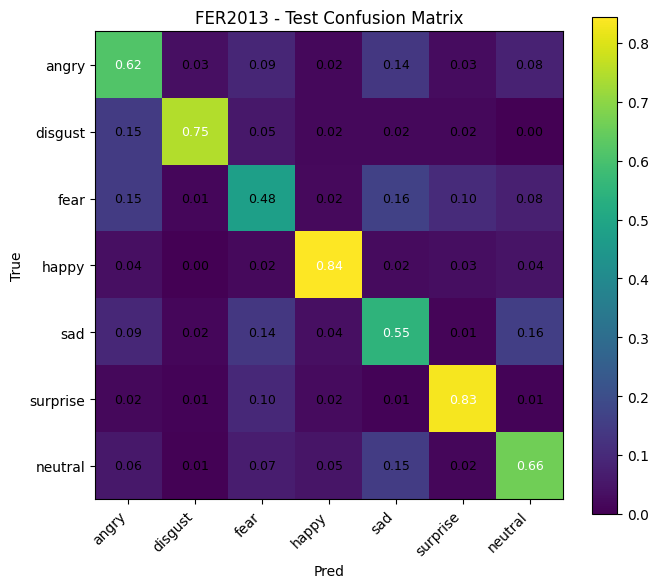

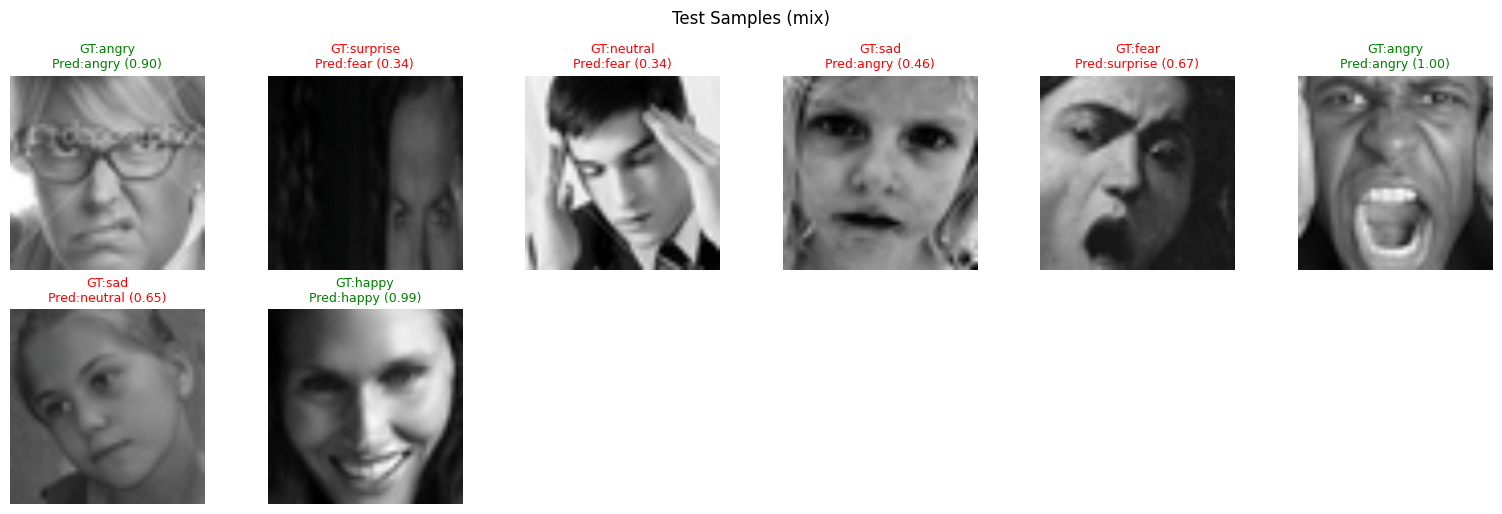

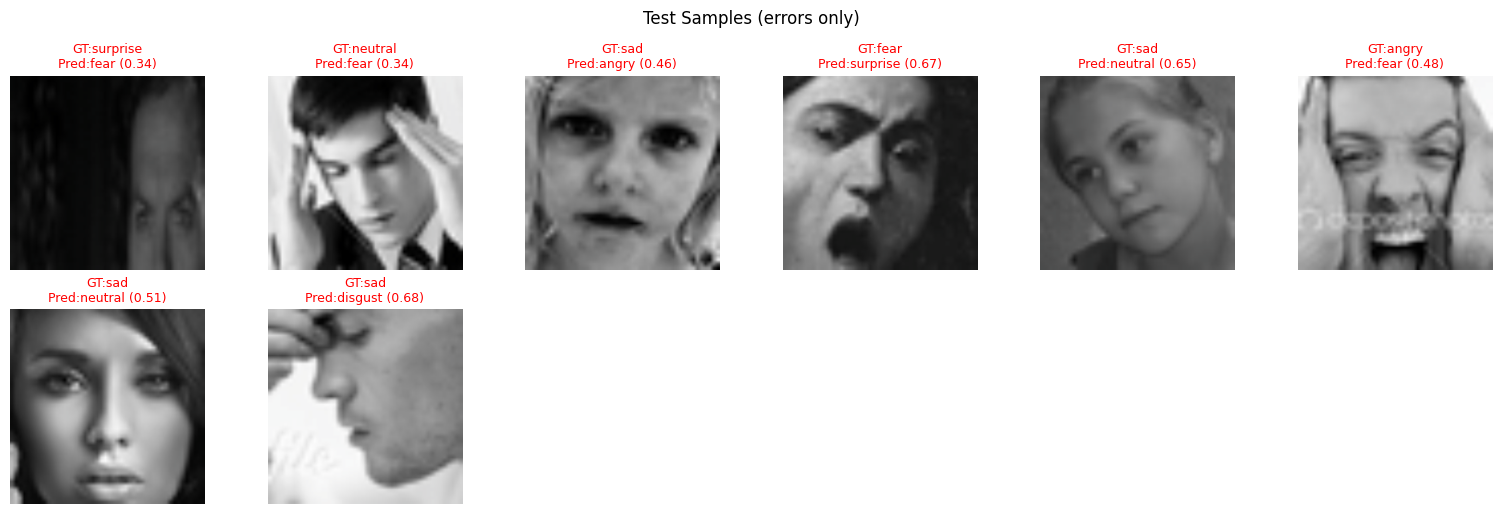

In [13]:
from mobilenet.mobilenet_3 import MobileNetV3Large
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device : {device}")
model = MobileNetV3Large(num_classes=7).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

model_path = "mobilenetv3_large_fer2013_best.pth"
print(f'model exist : {os.path.exists(model_path)}')
# 모델을 평가 모드로 전환
model.load_state_dict(torch.load(model_path, map_location=device)['state_dict'])
model.eval()

preds, probs, gts, samples = predict_all(model, test_loader, device=device)

    # 4) 지표 출력
acc = accuracy_score(gts, preds)
f1m = f1_score(gts, preds, average="macro")
print(f"TEST  Acc: {acc:.4f} | F1(macro): {f1m:.4f}")
print(classification_report(gts, preds, target_names=classes, digits=3))

# 5) 혼동행렬
cm = confusion_matrix(gts, preds, labels=list(range(len(classes))))
plot_confusion_matrix(cm, classes, normalize=True, title="FER2013 - Test Confusion Matrix")
plt.show()

# 6) 갤러리 (전체 샘플)
show_gallery(samples, classes, n=8, only_errors=False, title="Test Samples (mix)")
plt.show()

# 7) 갤러리 (오답만)
show_gallery(samples, classes, n=8, only_errors=True, title="Test Samples (errors only)")
plt.show()

# show_batch_grid(test_loader, model, device=device,
#                     n=8, cols=4,
#                     only_errors='store_true',
#                     save_path=(""))